<a href="https://colab.research.google.com/github/pillaisamarth/clg-proj/blob/main/trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [4]:
tech_list = [
    'GOOG',
    'MSFT'
]

end = datetime.now()
start = datetime(end.year - 4, end.month, end.day)

for stocks in tech_list:
    globals()[stocks] = yf.download(stocks, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [88]:
df = pd.DataFrame(GOOG[['Adj Close']].copy())
df.head()

,Adj Close
Date,
2018-10-15 00:00:00-04:00,54.612499
2018-10-16 00:00:00-04:00,56.063999
2018-10-17 00:00:00-04:00,55.784500
2018-10-18 00:00:00-04:00,54.398499
2018-10-19 00:00:00-04:00,54.823002


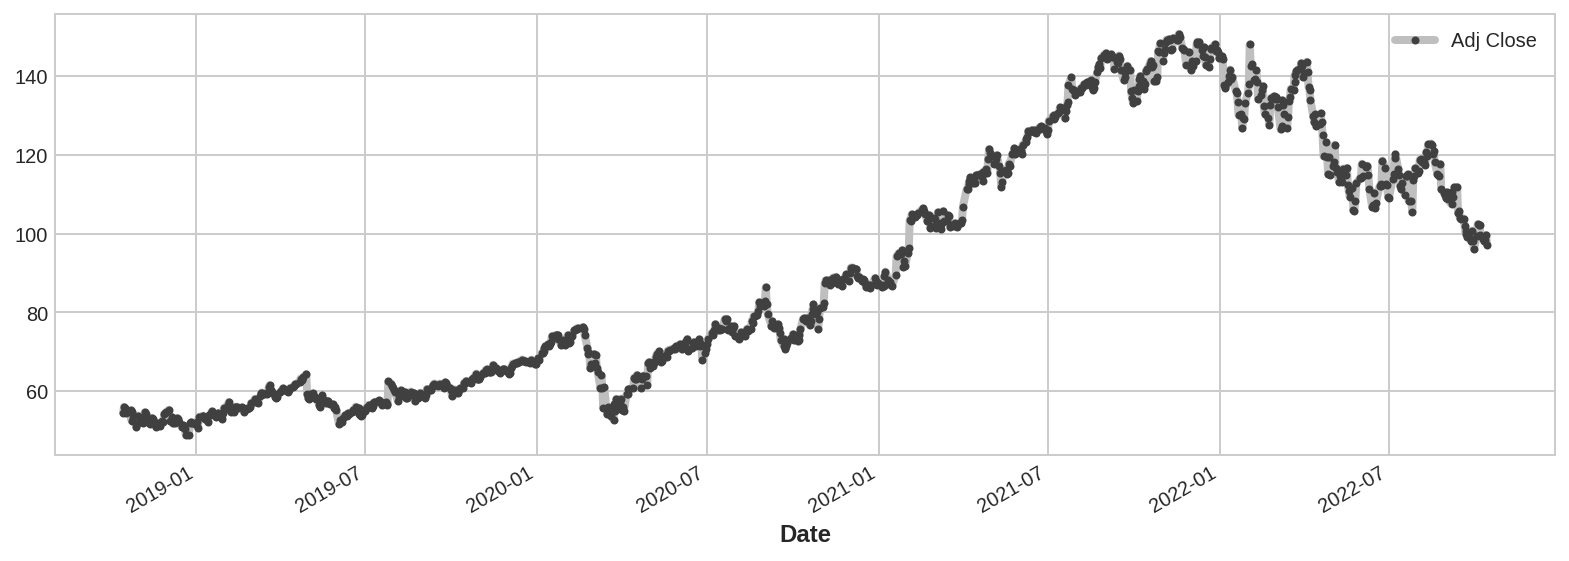

In [89]:
ax = df.plot(**plot_params)

In [90]:
from sklearn.model_selection import train_test_split
def data_split(X, y, test_size = 0.2):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
  return (X_train, X_test, y_train, y_test)

In [91]:
moving_average = df.rolling(
    window = 365,
    center = True,
    min_periods = 183,
).mean()
print(moving_average)

                            Adj Close
Date                                 
2018-10-15 00:00:00-04:00   55.684303
2018-10-16 00:00:00-04:00   55.691584
2018-10-17 00:00:00-04:00   55.699795
2018-10-18 00:00:00-04:00   55.708102
2018-10-19 00:00:00-04:00   55.717776
...                               ...
2022-10-10 00:00:00-04:00  119.581048
2022-10-11 00:00:00-04:00  119.494645
2022-10-12 00:00:00-04:00  119.418905
2022-10-13 00:00:00-04:00  119.360900
2022-10-14 00:00:00-04:00  119.300730

[1008 rows x 1 columns]


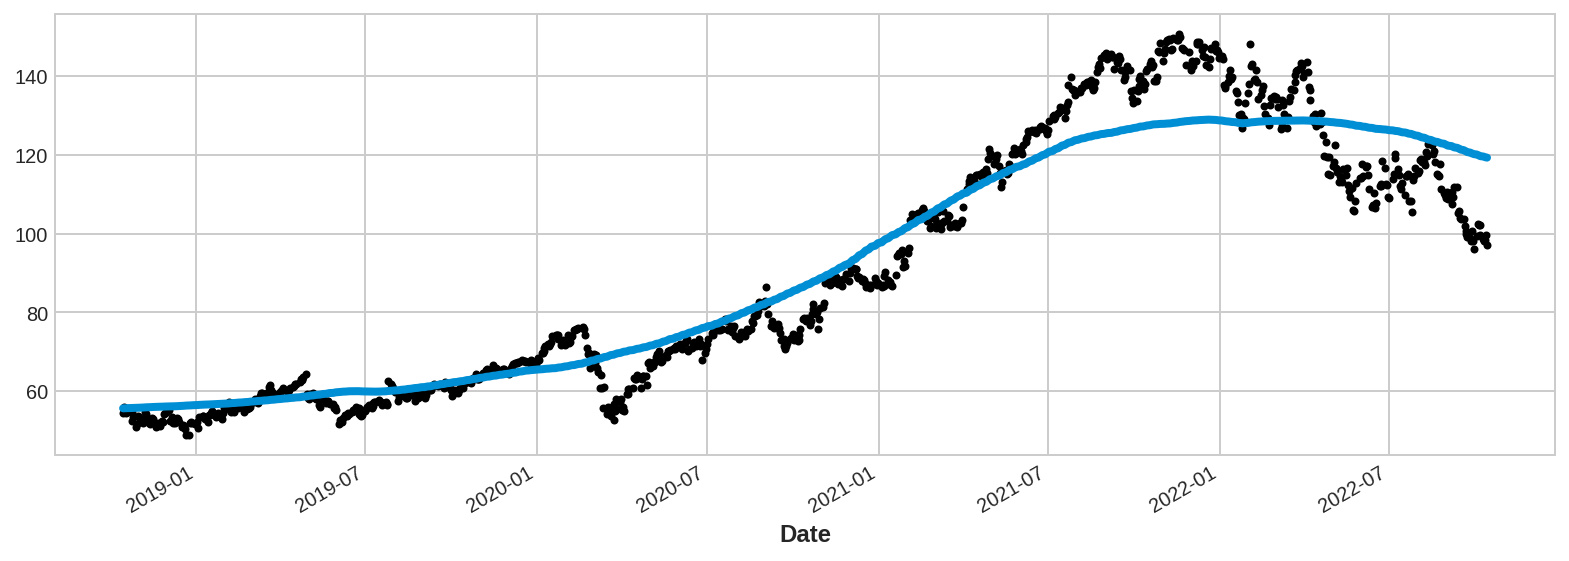

In [92]:
ax = df.plot(color='0', style='.', legend = False)
ax = moving_average.plot(ax = ax, legend = False)

In [111]:
from statsmodels.tsa.deterministic import DeterministicProcess
# adding dummy features to learn trend
dp = DeterministicProcess(
    index = df.index,
    constant = True,
    order = 4,
    drop = True
)

X = dp.in_sample()

print(X)

                           const   trend  trend_squared   trend_cubed  \
Date                                                                    
2018-10-15 00:00:00-04:00    1.0     1.0            1.0  1.000000e+00   
2018-10-16 00:00:00-04:00    1.0     2.0            4.0  8.000000e+00   
2018-10-17 00:00:00-04:00    1.0     3.0            9.0  2.700000e+01   
2018-10-18 00:00:00-04:00    1.0     4.0           16.0  6.400000e+01   
2018-10-19 00:00:00-04:00    1.0     5.0           25.0  1.250000e+02   
...                          ...     ...            ...           ...   
2022-10-10 00:00:00-04:00    1.0  1004.0      1008016.0  1.012048e+09   
2022-10-11 00:00:00-04:00    1.0  1005.0      1010025.0  1.015075e+09   
2022-10-12 00:00:00-04:00    1.0  1006.0      1012036.0  1.018108e+09   
2022-10-13 00:00:00-04:00    1.0  1007.0      1014049.0  1.021147e+09   
2022-10-14 00:00:00-04:00    1.0  1008.0      1016064.0  1.024193e+09   

                               trend**4  
Date    

In [112]:
X_train1, X_test1, y_train1, y_test1 = data_split(X, df.loc[:, ['Adj Close']])

In [113]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train1, y_train1)

LinearRegression(fit_intercept=False)

In [114]:
from sklearn.metrics import mean_squared_error, accuracy_score
def get_score(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)

In [115]:

y_pred1 = pd.Series(model.predict(X_test1).reshape(-1), index = X_test1.index)
error = get_score(y_test1, y_pred1)
print(error)

1401.6354587003218


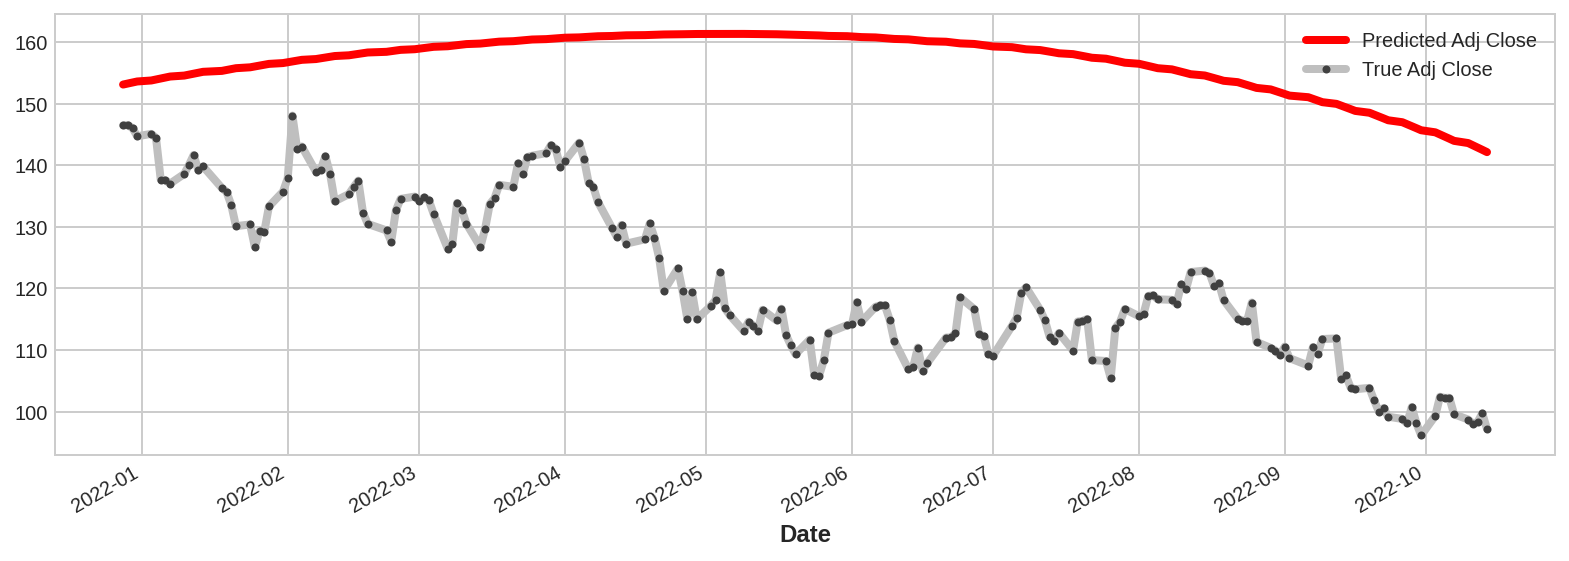

In [116]:
ax = y_pred1.plot(color='r')
ax = y_test1.plot(ax = ax, **plot_params)
ax.legend(['Predicted Adj Close', 'True Adj Close'])

In [117]:
y_train_pred1 = pd.Series(model.predict(X_train1).reshape(-1), index = X_train1.index)
error = get_score(y_train1, y_train_pred1)
print(error)

21.460510850154343


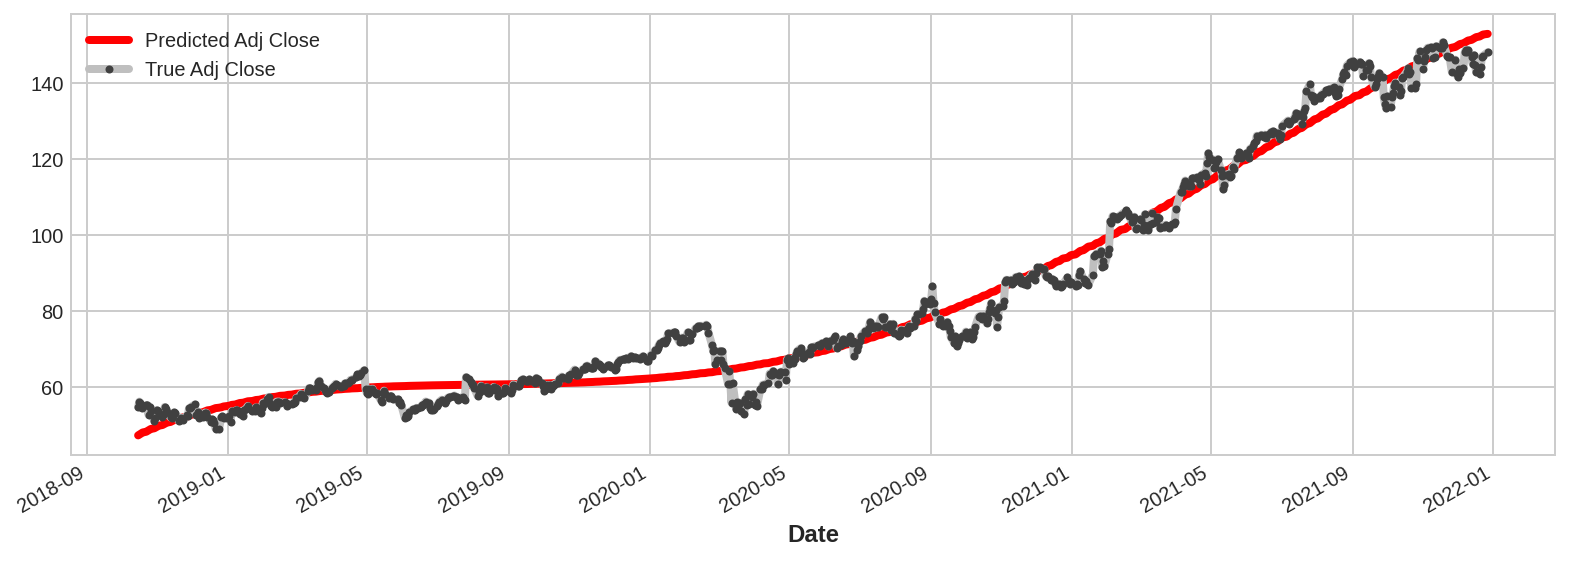

In [118]:
ax = y_train_pred1.plot(color='r', legend=True)
ax = y_train1.plot(ax = ax, **plot_params)
ax.legend(['Predicted Adj Close', 'True Adj Close'])

In [101]:
tmp = dp.out_of_sample(steps=30)
trend_fore = pd.Series(model.predict(tmp).reshape(-1), index = tmp.index)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  UserWarning,


In [102]:
trend_fore

1009    141.732801
1010    141.350381
1011    140.963638
1012    140.572556
1013    140.177116
1014    139.777301
1015    139.373092
1016    138.964471
1017    138.551421
1018    138.133923
1019    137.711959
1020    137.285512
1021    136.854562
1022    136.419092
1023    135.979083
1024    135.534518
1025    135.085378
1026    134.631644
1027    134.173299
1028    133.710323
1029    133.242699
1030    132.770409
1031    132.293433
1032    131.811753
1033    131.325350
1034    130.834207
1035    130.338304
1036    129.837624
1037    129.332146
1038    128.821853
dtype: float64

In [121]:
trend_train = pd.Series(model.predict(X).reshape(-1), index = np.arange(len(X.index)))

Text(0.5, 1.0, 'Trend forecast for 30 days')

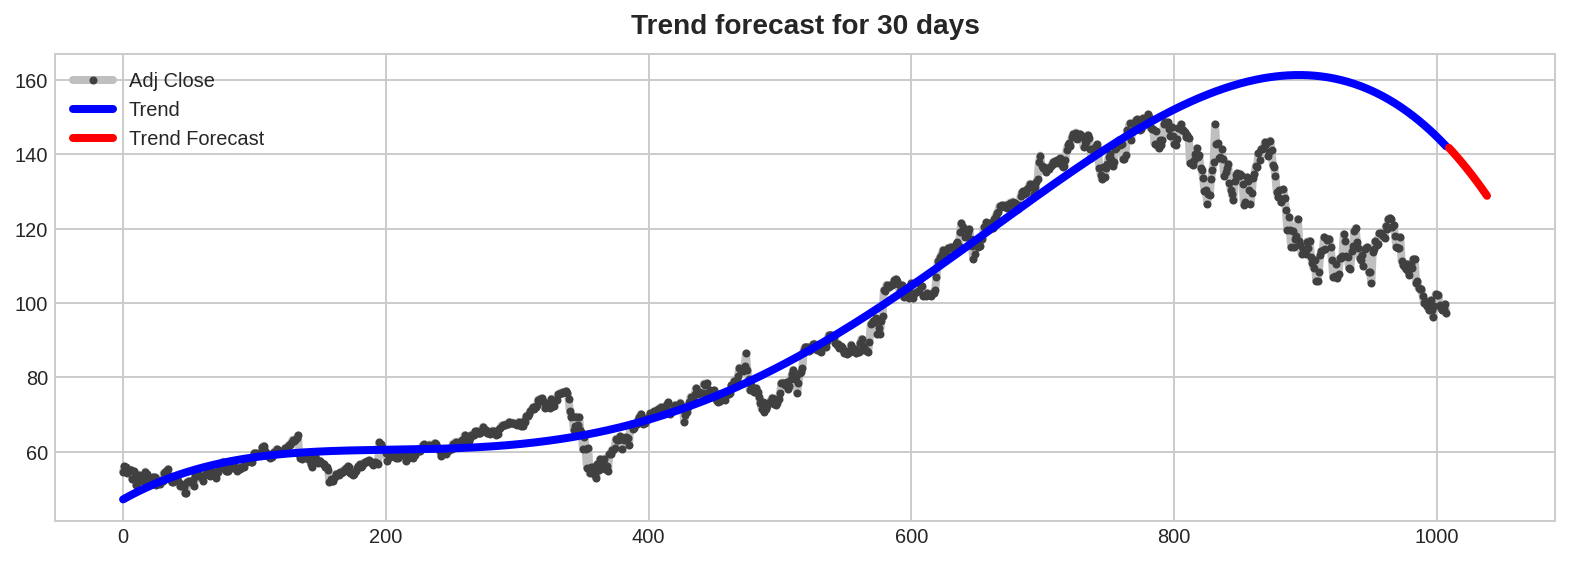

In [132]:
dummy = df.copy()
dummy.index = (np.arange(len(df.index)))
ax = dummy.plot(**plot_params)
ax = trend_train.plot(ax = ax, color='b')
ax = trend_fore.plot(ax = ax, color = 'r')
ax.legend(['Adj Close', 'Trend', 'Trend Forecast'])
ax.set_title('Trend forecast for 30 days')

In [127]:
dummy = df.copy()
dummy.index = np.arange(len(df.index))
print(dummy.head())

   Adj Close
0  54.612499
1  56.063999
2  55.784500
3  54.398499
4  54.823002
